In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import math

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import pyplot as plt
plt.ioff()

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, BatchNormalization
from keras.callbacks import EarlyStopping

import datetime as dt

Using TensorFlow backend.


In [2]:
path = "C:/Users/OPTIMUSPRIME/Desktop/Studia/Magisterka/"
BP_filename = "BP.csv"
HR_filename = "HR.csv"

train_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/training_set.txt").values.tolist()]
test_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/test_set.txt").values.tolist()]
validation_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/validation_set.txt").values.tolist()]
all_indices = train_indices + test_indices + validation_indices

In [3]:
def shift(xs, n):
    if n >= 0:
        return np.concatenate((np.full(n, np.nan), xs[:-n]))
    else:
        return np.concatenate((xs[-n:], np.full(-n, np.nan)))

    
def series_to_supervised(share_prices, timestamps, input_time_steps, dropnan=True):
    share_prices_df = pd.DataFrame(share_prices)
    timestamps_df = pd.DataFrame(timestamps)
    share_prices_timeseries = list()
    timestamps_timeseries = list()
    
    for i in range(input_time_steps-1, -1, -1):
        share_prices_timeseries.append(share_prices_df.shift(i))
        timestamps_timeseries.append(timestamps_df.shift(i))
    
    aggregated_share_prices = pd.concat(share_prices_timeseries, axis=1)
    aggregated_timestamps = pd.concat(timestamps_timeseries, axis=1)
    
    if dropnan:
        aggregated_share_prices.dropna(inplace=True)
        aggregated_timestamps.dropna(inplace=True)

    aggregated_timestamps = aggregated_timestamps.values
    aggregated_share_prices = aggregated_share_prices.values
    
    not_overlapping_indexes = range(0, 
                                    len(aggregated_share_prices), 
                                    input_time_steps)
    
    aggregated_timestamps = aggregated_timestamps[not_overlapping_indexes]
    aggregated_share_prices = aggregated_share_prices[not_overlapping_indexes]
    return aggregated_share_prices, aggregated_timestamps
 

def split(BP_data, HR_data, col, time_steps):
    X = []
    y = []

    BP_supervised, HR_supervised = series_to_supervised(BP_data[col], HR_data[col], time_steps)
    for BP_interval, HR_interval in zip(BP_supervised, HR_supervised):
        BP_HR_interval = []
        for BP_time_step, HR_time_step in zip(BP_interval, HR_interval):
            BP_HR_interval.append([BP_time_step, HR_time_step])
        X.append(BP_HR_interval)
        if labels[col] == 'Synkope': label = [0., 1.] 
        else: label = [1., 0.]
        y.append(label)
    return np.array(X), np.array(y)


def split_df(BP_data, HR_data, time_steps):
    X = np.array([])
    y = np.array([])
    for col in BP_data:
        X_single, y_single = split(BP_data, HR_data, col, time_steps)
        if X.size == 0:
            X = X_single
            y = y_single
        else:
            X = np.concatenate((X, X_single))
            y = np.concatenate((y, y_single))
    return np.array(X), np.array(y)

In [4]:
BP_data = pd.read_csv(path + "DATA/" + BP_filename, low_memory=False)[all_indices]
HR_data = pd.read_csv(path + "DATA/" + HR_filename, low_memory=False)[all_indices]
labels = {col: BP_data[col].iloc[0] for col in BP_data}

BP_max_value = BP_data.iloc[1:].astype(np.float32).max().max()
BP_min_value = BP_data.iloc[1:].astype(np.float32).min().min()
HR_max_value = HR_data.iloc[1:].astype(np.float32).max().max()
HR_min_value = HR_data.iloc[1:].astype(np.float32).min().min()

BP_scaler = MinMaxScaler().fit(np.array([BP_min_value, BP_max_value]).reshape(-1,1))
HR_scaler = MinMaxScaler().fit(np.array([HR_min_value, HR_max_value]).reshape(-1,1))

BP_data_scaled = BP_data.iloc[1:].astype(np.float32).copy()
BP_data_scaled[all_indices] = BP_scaler.transform(BP_data_scaled[all_indices])

HR_data_scaled = HR_data.iloc[1:].astype(np.float32).copy()
HR_data_scaled[all_indices] = HR_scaler.transform(HR_data_scaled[all_indices])

In [5]:
part_to_drop = 0.4
BP_data_scaled_trimmed = BP_data_scaled.copy()
HR_data_scaled_trimmed = HR_data_scaled.copy()
for col in BP_data_scaled_trimmed:
    n_rows_to_drop = int(part_to_drop * np.count_nonzero(~np.isnan(BP_data_scaled_trimmed[col])))

    BP_data_scaled_trimmed[col] = shift(BP_data_scaled_trimmed[col], -n_rows_to_drop)
    HR_data_scaled_trimmed[col] = shift(HR_data_scaled_trimmed[col], -n_rows_to_drop)

In [6]:
# time_steps = [32, 64, 128]
time_steps = [64, 32] 
# r_layers = [0, 2, 3, 4]
r_layers = [2]
# LSTM_cells = [1, 16, 64, 256]
LSTM_cells = [64]
# neurons = [5, 20, 50]
neurons = [5]
# epochs = [1, 2, 3, 4, 5]
epochs = [3]
# batch_size = [32, 64, 128]
batch_size = [128]

W1228 21:50:57.893934 15852 deprecation_wrapper.py:119] From C:\Programs\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1228 21:50:57.911513 15852 deprecation_wrapper.py:119] From C:\Programs\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1228 21:50:57.915483 15852 deprecation_wrapper.py:119] From C:\Programs\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1228 21:50:58.433557 15852 deprecation_wrapper.py:119] From C:\Programs\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1228 21:50:58.464513 15852 deprecation_wrapper.py:119] From C:\Programs\Anaconda3\lib\site-

Train on 5144 samples, validate on 616 samples
Epoch 1/3
5144/5144 [==============================] - 6s 1ms/step - loss: 0.6808 - acc: 0.5572 - val_loss: 0.6680 - val_acc: 0.5795cc: 0.55
Epoch 2/3
5144/5144 [==============================] - ETA: 0s - loss: 0.6667 - acc: 0.6006- ETA: 0s - loss: 0.6672 - acc: 0.6 - 4s 736us/step - loss: 0.6665 - acc: 0.6007 - val_loss: 0.6384 - val_acc: 0.6753
Epoch 3/3
5144/5144 [==============================] - 4s 720us/step - loss: 0.6468 - acc: 0.6289 - val_loss: 0.6374 - val_acc: 0.6429
Train on 10369 samples, validate on 1242 samples
Epoch 1/3
10369/10369 [==============================] - 5s 494us/step - loss: 0.6903 - acc: 0.5520 - val_loss: 0.6896 - val_acc: 0.5451
Epoch 2/3
10369/10369 [==============================] - 4s 348us/step - loss: 0.6876 - acc: 0.5557 - val_loss: 0.6891 - val_acc: 0.5451
Epoch 3/3
10369/10369 [==============================] - 4s 359us/step - loss: 0.6872 - acc: 0.5557 - val_loss: 0.6891 - val_acc: 0.5451


C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


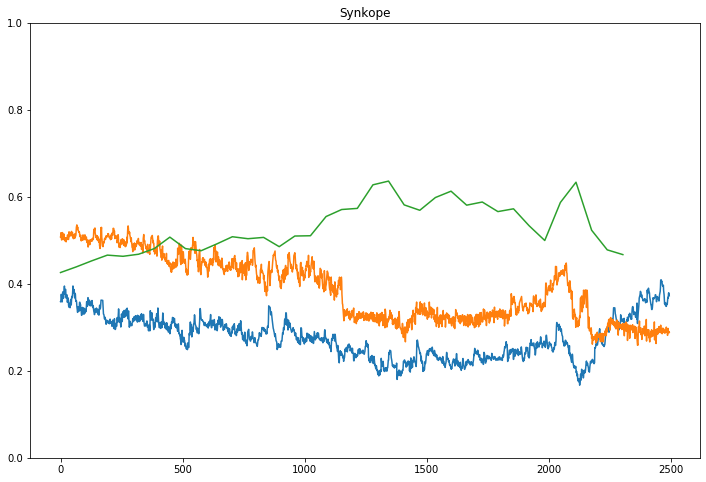

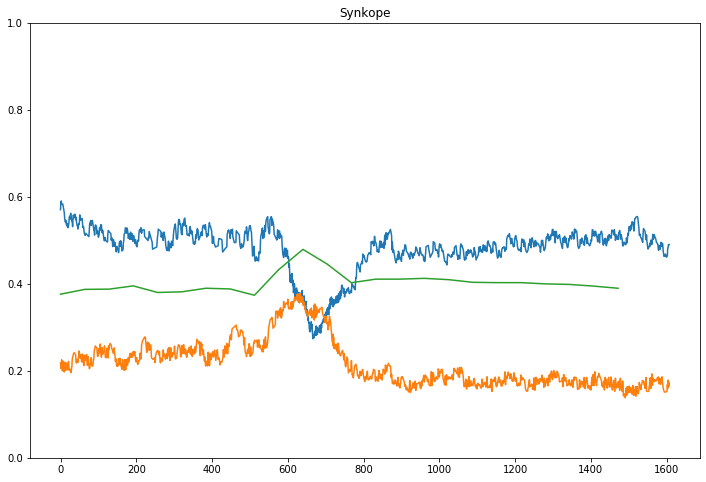

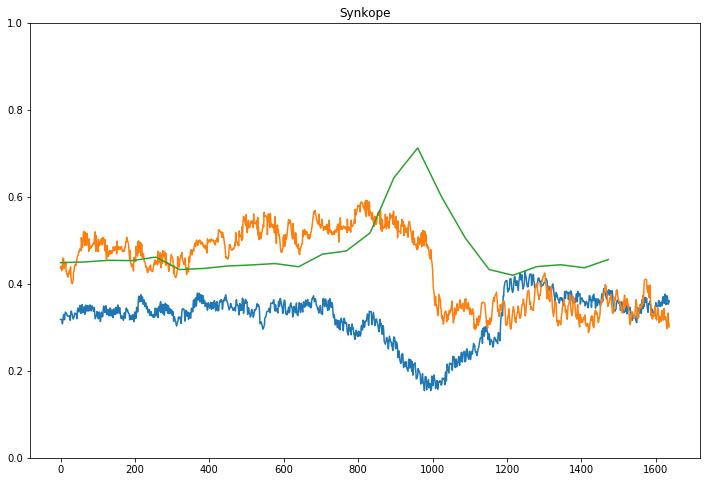

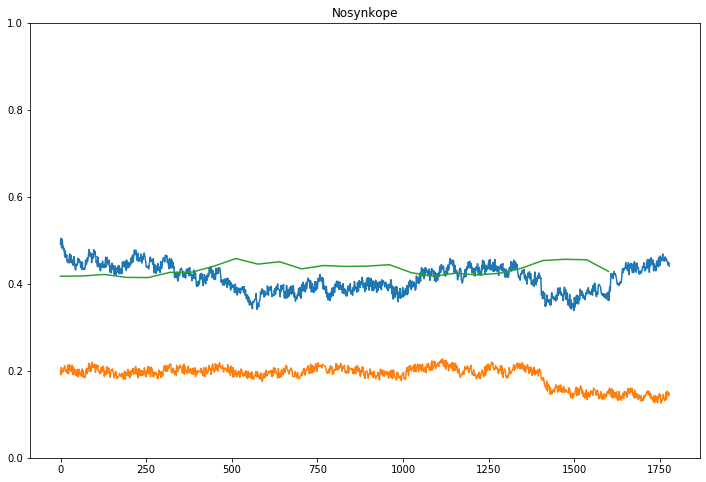

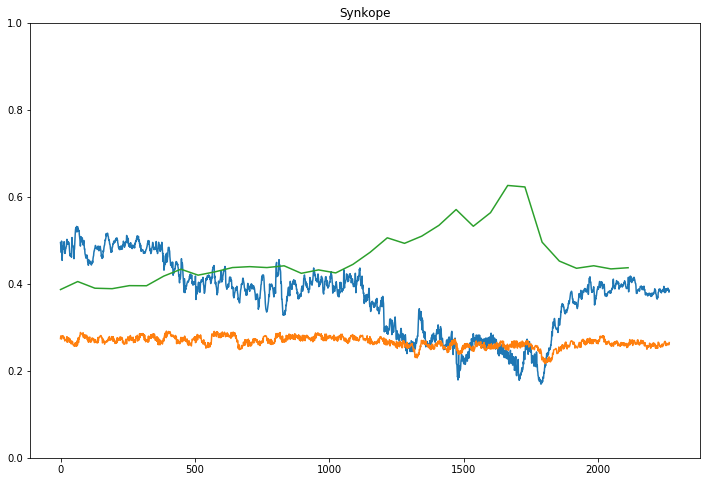

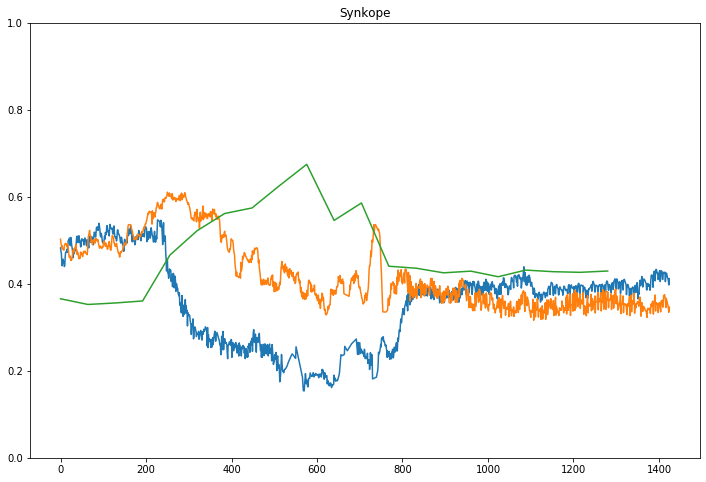

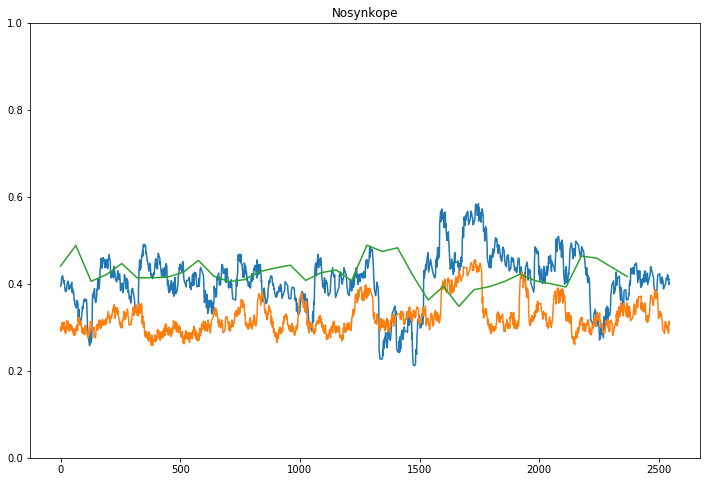

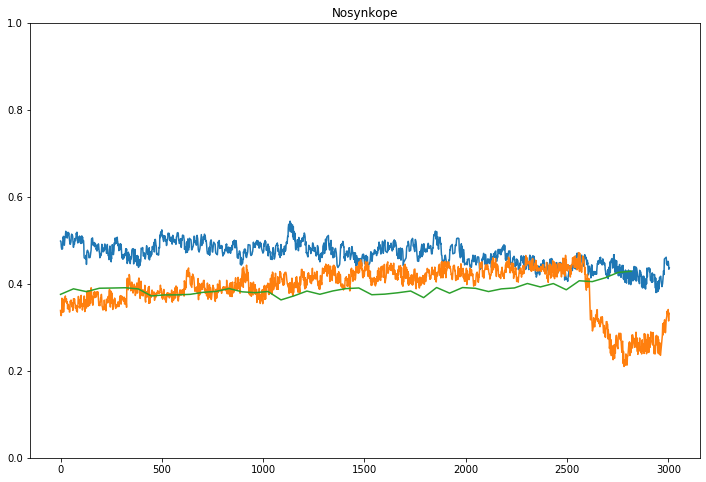

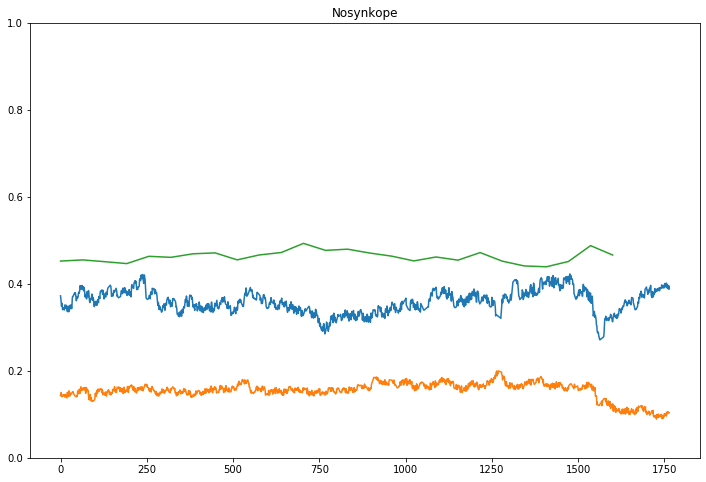

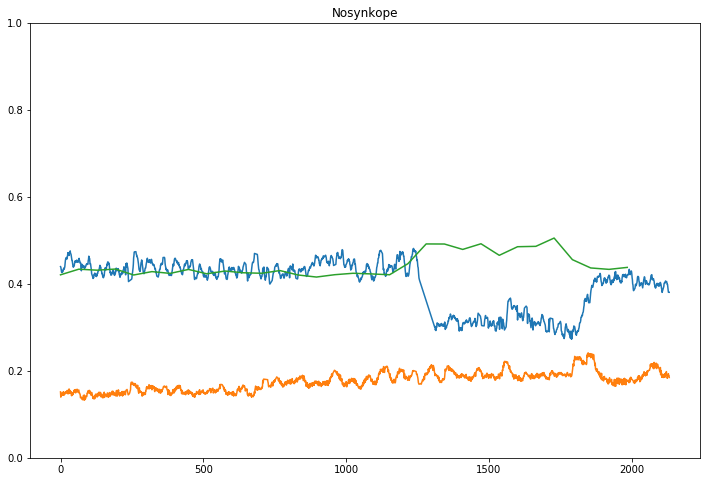

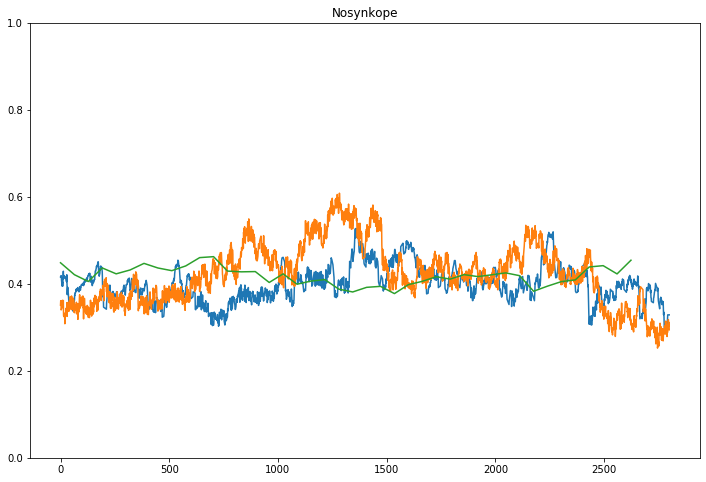

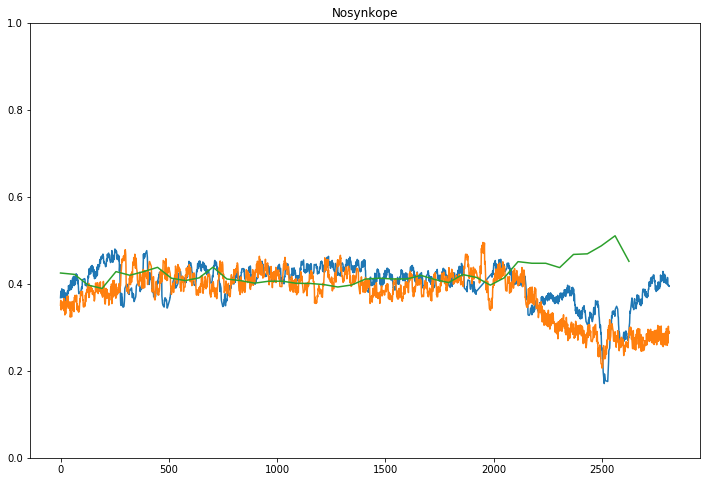

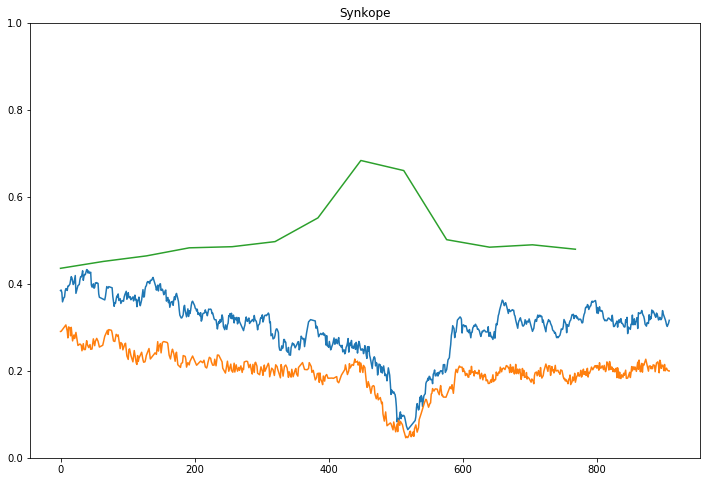

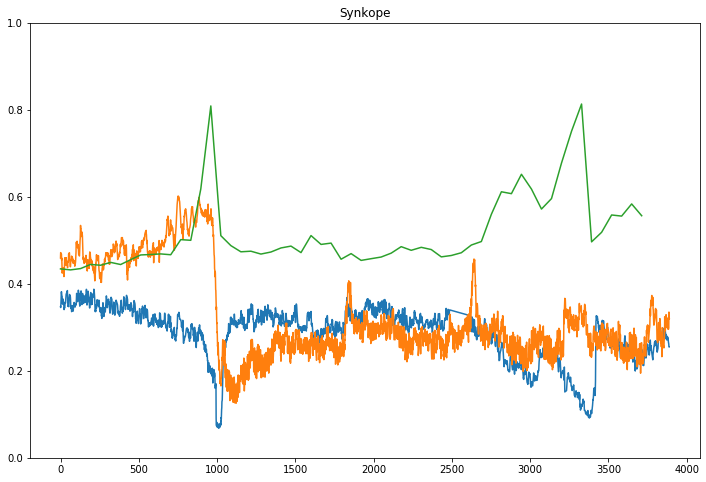

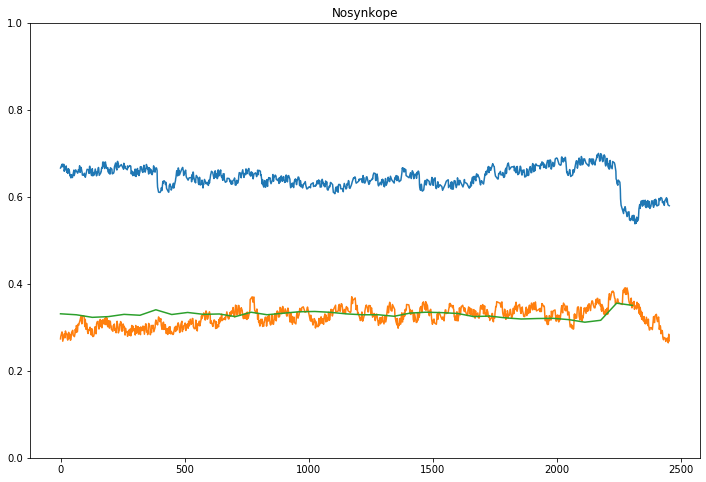

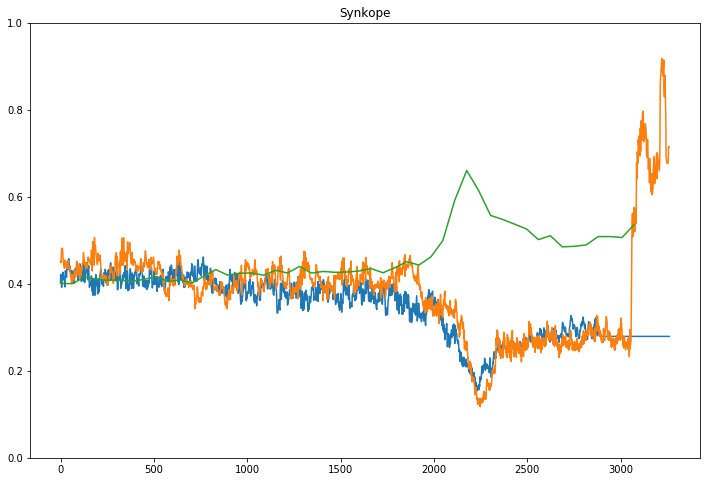

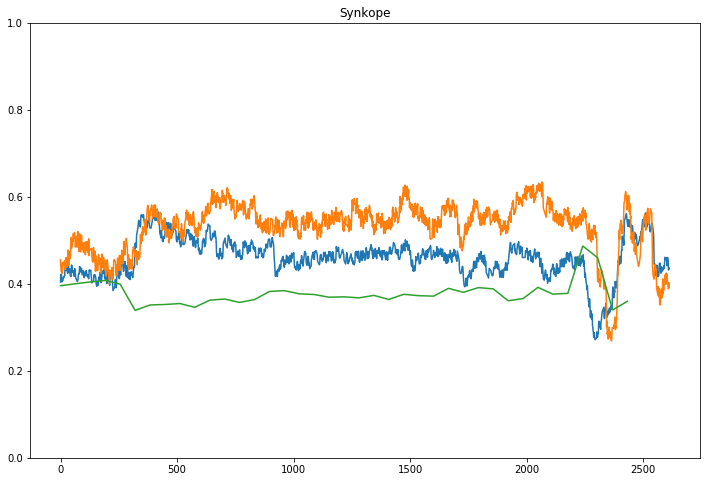

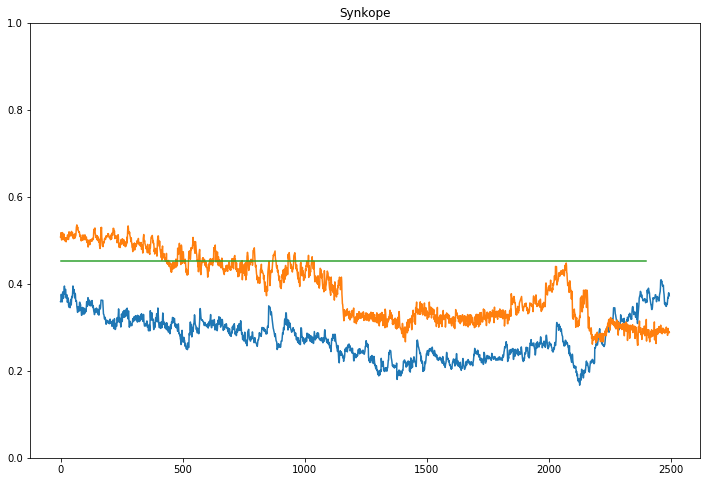

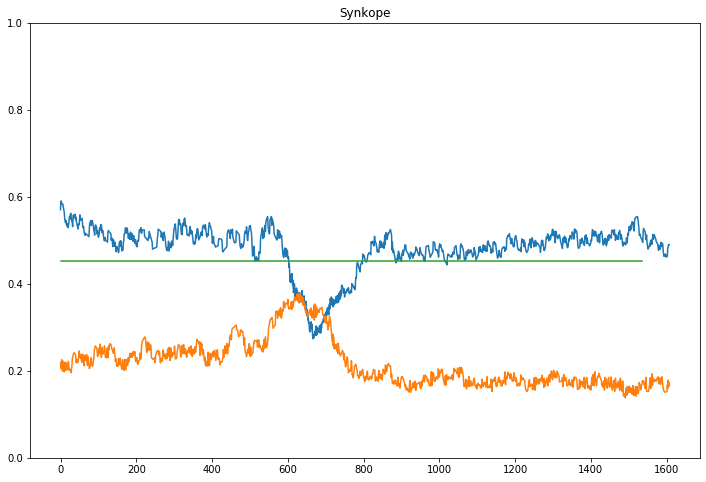

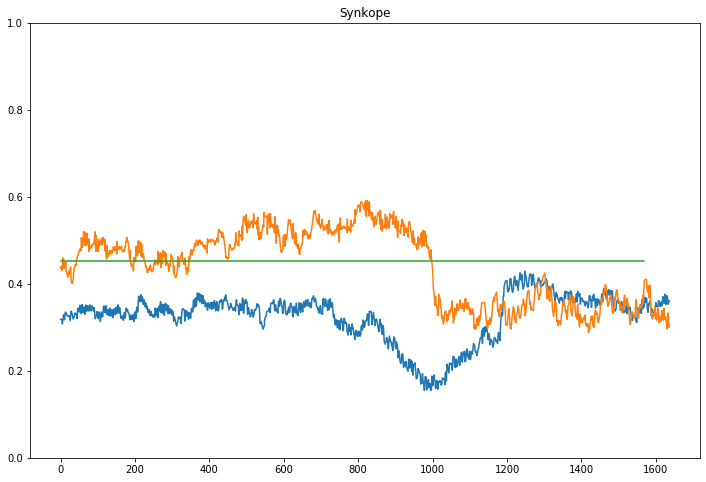

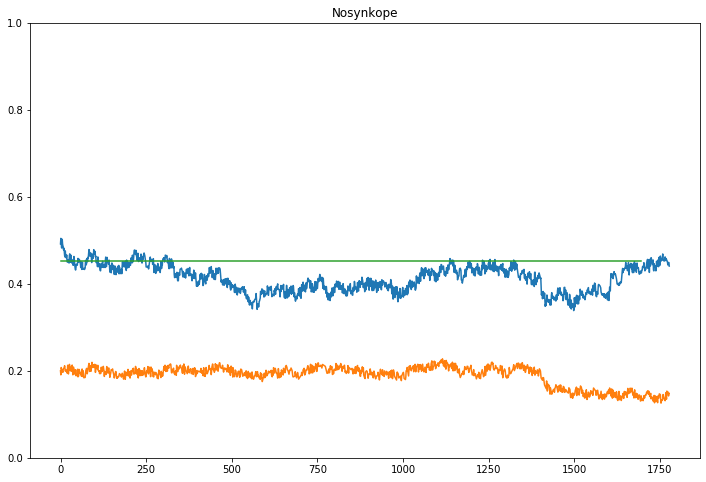

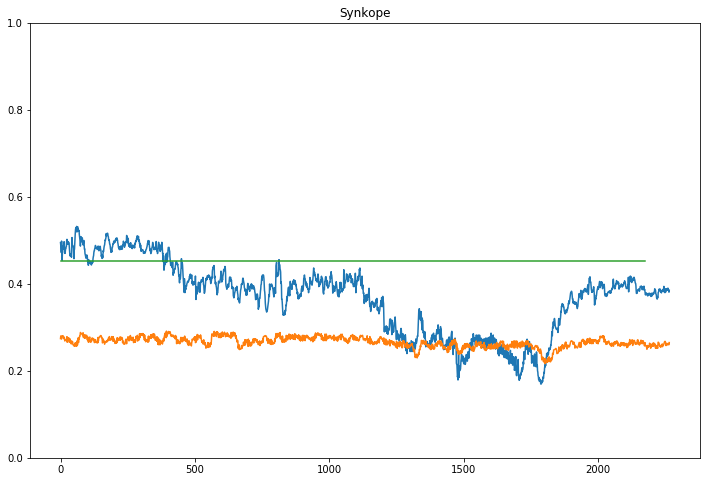

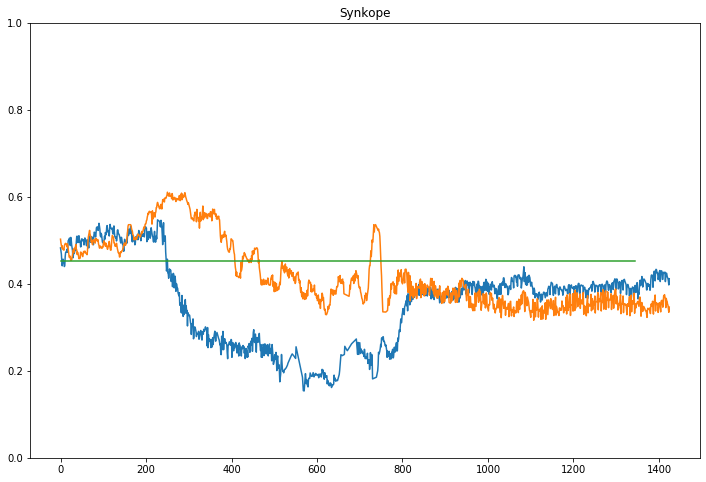

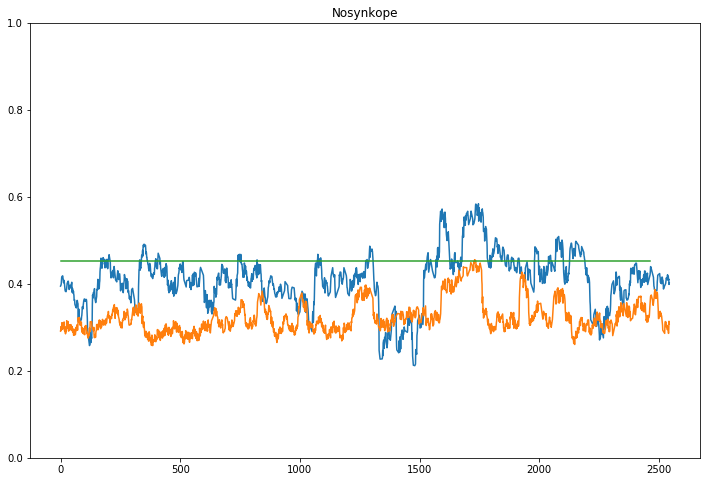

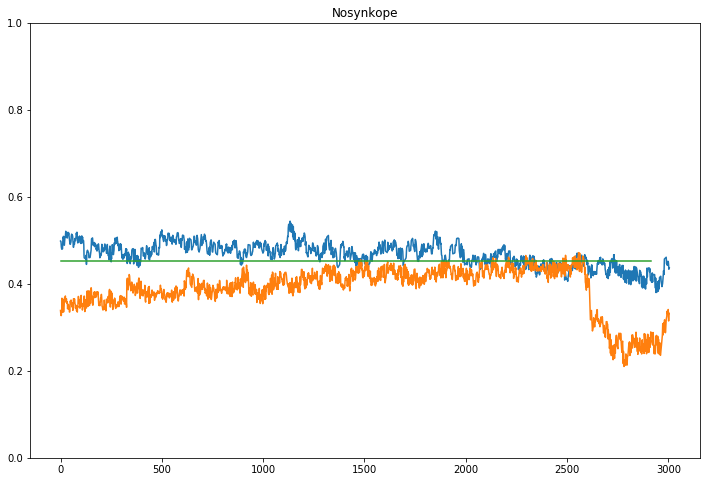

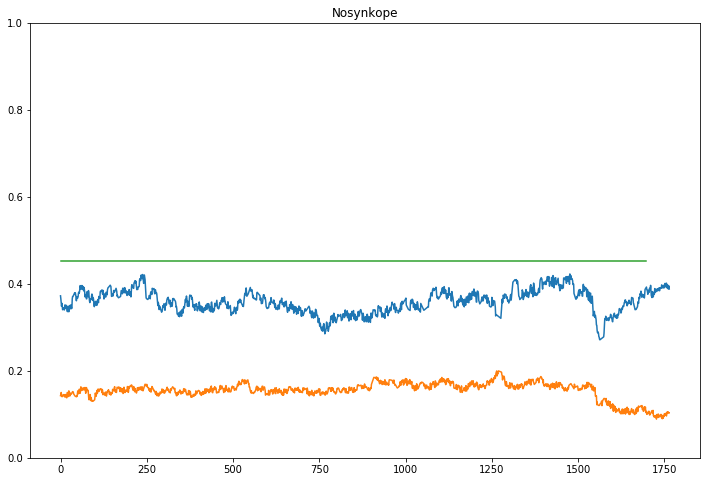

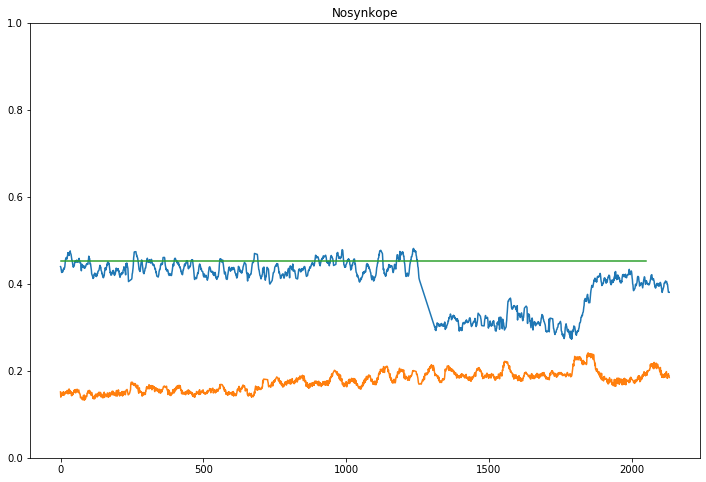

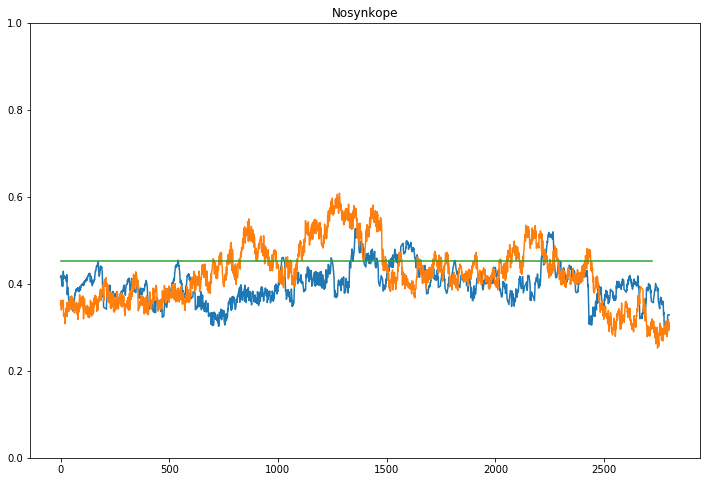

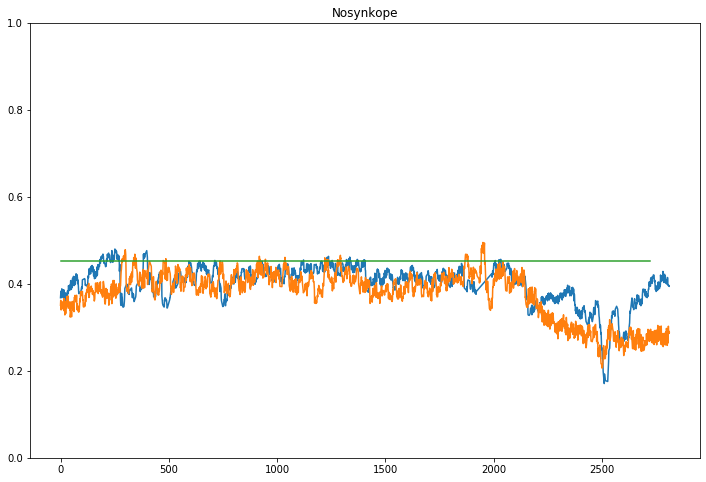

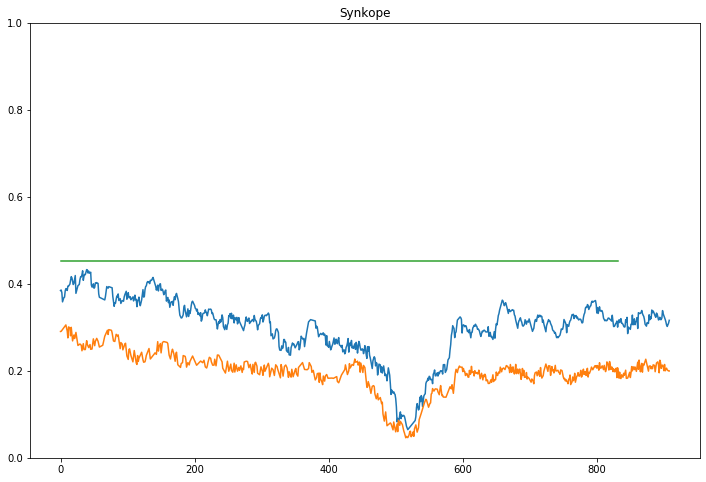

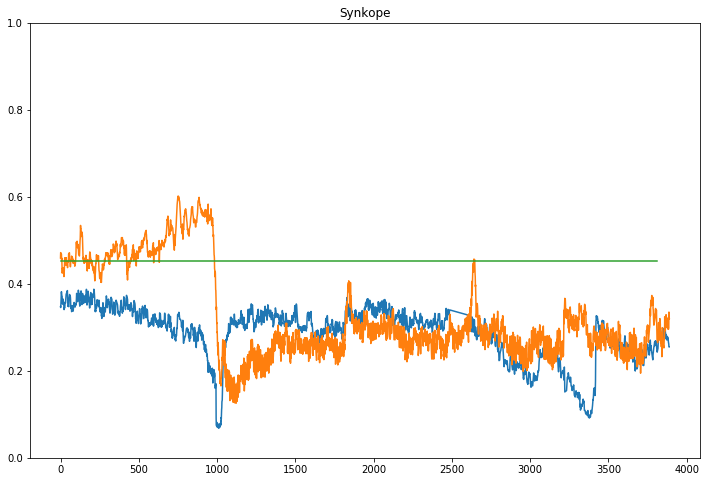

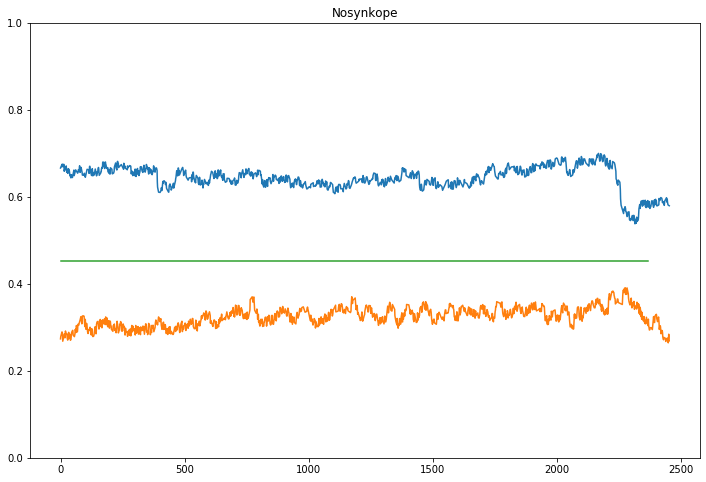

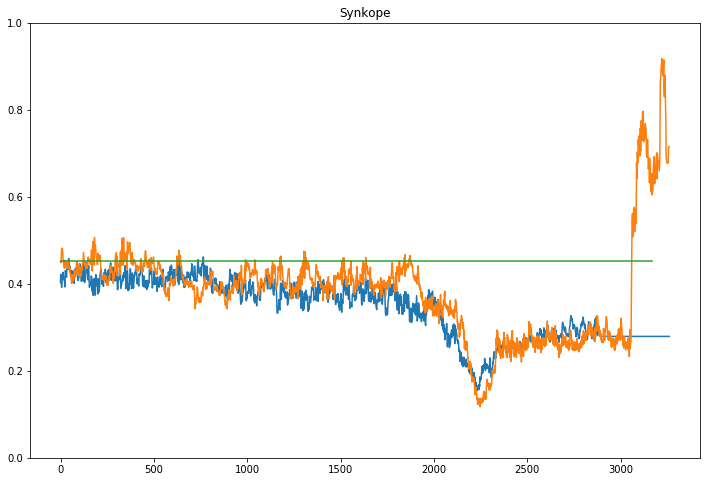

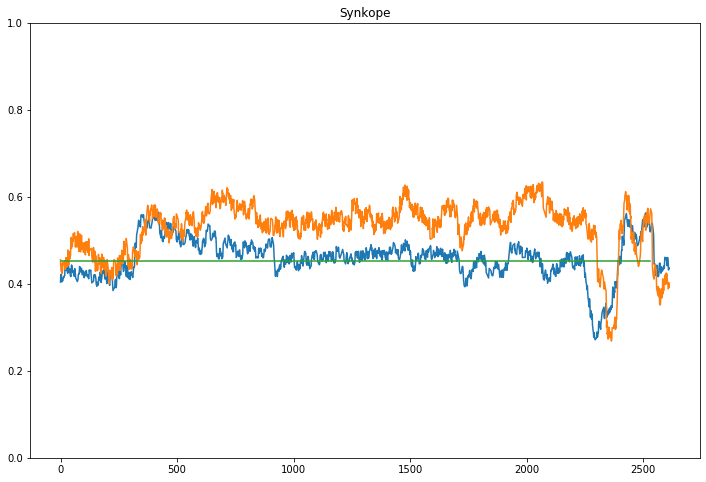

In [7]:
for ts in time_steps:
    X_train, y_train = split_df(BP_data_scaled_trimmed[train_indices], HR_data_scaled_trimmed[train_indices], ts)
    X_test, y_test = split_df(BP_data_scaled_trimmed[test_indices], HR_data_scaled_trimmed[test_indices], ts)
    for rl in r_layers:
        for c in LSTM_cells:
            for n in neurons:
                model = Sequential()
                if rl == 1:
                    model.add(LSTM(c, input_shape=(X_train.shape[1], X_train.shape[2])))
                if rl == 2:
                    model.add(LSTM(c, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
                    model.add(LSTM(c))
                else:
                    model.add(LSTM(c, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
                    for _ in range(rl - 2):
                        model.add(LSTM(c, return_sequences=True))
                    model.add(LSTM(c))
                model.add(Dense(n, activation='relu'))
                model.add(Dense(y_train.shape[1], activation='softmax'))
                model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
                for e in epochs:
                    for bs in batch_size:
                        hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=e, batch_size=bs, verbose=1)
                        acc = int(hist.history['acc'][-1]*100)
                        os.mkdir("LSTM_results/" + f"{acc}TS{ts}_RL{rl}_C{c}_N{n}_E{e}_BS{bs}")
                        for ind in validation_indices:
                            plt.figure(figsize=(12,8))
                            X_val, y_val = split(BP_data_scaled_trimmed, HR_data_scaled_trimmed, ind, ts)
                            y_val_pred = model.predict(X_val)

                            bp = BP_data_scaled_trimmed[ind].dropna().tolist()
                            hr = HR_data_scaled_trimmed[ind].dropna().tolist()
                            mult = int(len(bp) / ts - 1)

                            plt.title(labels[ind])
                            plt.plot(bp)
                            plt.plot(hr)
                            plt.ylim((0,1))
                            plt.plot(range(0, mult * ts, ts), y_val_pred[:mult, 1])
                            plt.savefig(f"LSTM_results/" + f"TS{ts}_RL{rl}_C{c}_N{n}_E{e}_BS{bs}/{ind}.png")

In [14]:
int(hist.history['acc'][-1]*100)

55